In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
%cd drive/My\ Drive/hotdog/

/content/drive/My Drive/hotdog


In [2]:
!ls

checkpoint			    model_fin.ckpt.index
hotdog				    model_fin.ckpt.meta
load_data.py			    model.ipynb
model.ckpt.data-00000-of-00001	    nothotdog
model.ckpt.index		    preprocess.ipynb
model.ckpt.meta			    test
model_fin.ckpt.data-00000-of-00001


In [3]:
import numpy as np
import os
import cv2
size = 227

def load_data():
    hotdog = len(os.listdir('./hotdog'))
    nothotdog = len(os.listdir('./nothotdog'))
    datasetx = np.ndarray((hotdog+nothotdog, size, size, 3))
    datasety = np.ndarray((hotdog+nothotdog, 1))
    i = 0
    print(hotdog)
    print(nothotdog)
    #return 1,2
    print("H")
    for img in os.listdir('./hotdog'):
        mat = cv2.imread('./hotdog/'+img)
        datasetx[i] = mat
        datasety[i] = 1
        i+=1
        if(i%100==1):
          print(i,end=' ')
    print()
    print('NH')
    for img in os.listdir('./nothotdog'):
        mat = cv2.imread('./nothotdog/'+img)
        datasetx[i] = mat
        datasety[i] = 0
        i += 1
        if(i%100==1):
          print(i,end=' ')
    return datasetx, datasety

In [4]:
#from load_data import *
import numpy as np
import os
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import urllib
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
datasetx, datasety = load_data()
datasetx = datasetx/255

1090
1891
H
1 101 201 301 401 501 601 701 801 901 1001 
NH
1101 1201 1301 1401 1501 1601 1701 1801 1901 2001 2101 2201 2301 2401 2501 2601 2701 2801 2901 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(datasetx, datasety, test_size = 0.1, shuffle = True, stratify=datasety, random_state = 1)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2682, 227, 227, 3) (299, 227, 227, 3)
(2682, 1) (299, 1)


In [7]:
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, shape=(None, 227, 227, 3))
y = tf.placeholder(dtype=tf.float32, shape=(None, 1))

In [8]:
# Layer 1
w_1 = tf.Variable(tf.truncated_normal(shape=[11,11,3,96], stddev=0.01))
b_1 = tf.Variable(tf.zeros(shape=(96)))
c_1 = tf.nn.conv2d(X, w_1, strides=[1,4,4,1], padding="VALID")
c_1 = c_1 + b_1
c_1 = tf.nn.relu(c_1)
# Pooling 1
p_1 = tf.nn.max_pool(c_1, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='VALID')

In [9]:
# Layer 2
w_2 = tf.Variable(tf.truncated_normal([5,5,96,256], stddev=0.01))
b_2 = tf.Variable(tf.constant(1.0, shape=[[5,5,96,256][3]]))
c_2 = tf.nn.conv2d(p_1, w_2,strides=[1, 1, 1, 1], padding='SAME')
c_2 = c_2 + b_2
c_2 = tf.nn.relu(c_2)
# Pooling 2
p_2 = tf.nn.max_pool(c_2, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='VALID')

In [10]:
# Layer 3
w_3 = tf.Variable(tf.truncated_normal([3, 3, 256, 384], stddev=0.01))
b_3 = tf.Variable(tf.constant(0.0, shape=[[3, 3, 256, 384][3]]))
c_3 = tf.nn.conv2d(p_2, w_3,strides=[1, 1, 1, 1], padding='SAME')
c_3 = c_3 + b_3
c_3 = tf.nn.relu(c_3)

In [11]:
# Layer 4
w_4 = tf.Variable(tf.truncated_normal([3, 3, 384, 384], stddev=0.01))
b_4 = tf.Variable(tf.constant(0.0, shape=[[3, 3, 384, 384][3]]))
c_4 = tf.nn.conv2d(c_3, w_4,strides=[1, 1, 1, 1], padding='SAME')
c_4 = c_4 + b_4
c_4 = tf.nn.relu(c_4)

In [12]:
# Layer 5
w_5 = tf.Variable(tf.truncated_normal([3, 3, 384, 256], stddev=0.01))
b_5 = tf.Variable(tf.constant(0.0, shape=[[3, 3, 384, 256][3]]))
c_5 = tf.nn.conv2d(c_4, w_5,strides=[1, 1, 1, 1], padding='SAME')
c_5 = c_5 + b_5
c_5 = tf.nn.relu(c_5)
# Pooling 3
p_3 = tf.nn.max_pool(c_5, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='VALID')
# Flattening
flattened = tf.reshape(p_3,[-1,6*6*256])

In [13]:
# Fully Connected Layer 1
input_size = int( flattened.get_shape()[1] )
w1_fc = tf.Variable(tf.truncated_normal([input_size, 4096], stddev=0.01))
b1_fc = tf.Variable( tf.constant(1.0, shape=[4096] ) )
s_fc1 = tf.matmul(flattened, w1_fc) + b1_fc
s_fc1 = tf.nn.relu(s_fc1)
#Dropout Layer 1
hold_prob1 = tf.placeholder(tf.float32)
s_fc1 = tf.nn.dropout(s_fc1,keep_prob=hold_prob1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
# Fully Connected Layer 2
w2_fc = tf.Variable(tf.truncated_normal([4096, 4096], stddev=0.01))
b2_fc = tf.Variable( tf.constant(1.0, shape=[4096] ) )
s_fc2 = tf.matmul(s_fc1, w2_fc) + b2_fc
s_fc2 = tf.nn.relu(s_fc2)
#Dropout Layer 2
hold_prob2 = tf.placeholder(tf.float32)
s_fc2 = tf.nn.dropout(s_fc2,keep_prob=hold_prob1)

In [15]:
##Fully Connected Layer 3
w3_fc = tf.Variable(tf.truncated_normal([4096,1], stddev=0.01))
b3_fc = tf.Variable( tf.constant(1.0, shape=[1] ) )
y_pred = tf.matmul(s_fc2, w3_fc) + b3_fc
y_pred = tf.math.sigmoid(y_pred)
print(y_pred)

Tensor("Sigmoid:0", shape=(?, 1), dtype=float32)


In [16]:
# Defining Loss
lss = tf.keras.losses.binary_crossentropy(
    y,
    y_pred,
    from_logits=False,
    label_smoothing=0
)
log_loss = tf.losses.log_loss(y, y_pred)  
# Defining Optimizer
train = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(log_loss)

In [17]:
steps = X_train.shape[0]
step_size = 64
rem = steps%step_size
epochs = 80

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    for i in range(epochs):
        for j in range(0, steps-rem, step_size):
            _, c = sess.run([train,log_loss],
                            feed_dict={
                                X:X_train[j:j+step_size], 
                                y:y_train[j:j+step_size],
                                hold_prob1:0.5,
                                hold_prob2:0.5
                            })
        preds = sess.run(y_pred,feed_dict={X:X_test,hold_prob1:1.0,hold_prob2:1.0})
        acc = 0
        for k in range(len(y_test)):
          if((preds[k]>=0.6 and y_test[k]==1) or (preds[k]<0.6 and y_test[k]==0)):
            acc += 1
        preds = sess.run(y_pred,feed_dict={X:X_train,hold_prob1:1.0,hold_prob2:1.0})
        acct = 0
        for k in range(len(y_train)):
          if((preds[k]>=0.6 and y_train[k]==1) or (preds[k]<0.6 and y_train[k]==0)):
            acct += 1
        if((i+1)%10 == 0):
          print("Epoch "+str(i), end=' ')
          print("Train Acc.",acct/(len(y_train)), end=' ')
          print("Test Acc.:",acc/(len(y_test)), end = ' ')
          print("Log Loss:",c)
          save_path = saver.save(sess, "./model_fin.ckpt")
          print("Model saved in ", save_path)

Epoch 9 Train Acc. 0.6342281879194631 Test Acc.: 0.6354515050167224 Log Loss: 0.6977342
Model saved in  ./model_fin.ckpt
Epoch 19 Train Acc. 0.6554809843400448 Test Acc.: 0.6454849498327759 Log Loss: 0.5491743
Model saved in  ./model_fin.ckpt
Epoch 29 Train Acc. 0.7293064876957495 Test Acc.: 0.6923076923076923 Log Loss: 0.47329634
Model saved in  ./model_fin.ckpt
Epoch 39 Train Acc. 0.8411633109619687 Test Acc.: 0.6755852842809364 Log Loss: 0.3590569
Model saved in  ./model_fin.ckpt
Epoch 49 Train Acc. 0.9716629381058911 Test Acc.: 0.705685618729097 Log Loss: 0.109887846
Model saved in  ./model_fin.ckpt
Epoch 59 Train Acc. 0.9966442953020134 Test Acc.: 0.7190635451505016 Log Loss: 0.0021887857
Model saved in  ./model_fin.ckpt
Epoch 69 Train Acc. 0.9970171513795675 Test Acc.: 0.7157190635451505 Log Loss: 0.0002615948
Model saved in  ./model_fin.ckpt
Epoch 79 Train Acc. 0.9970171513795675 Test Acc.: 0.725752508361204 Log Loss: 0.00010468355
Model saved in  ./model_fin.ckpt


In [18]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "./model.ckpt")
    print("Model Restored")
    preds = sess.run(y_pred,feed_dict={X:X_test, hold_prob1:1.0,hold_prob2:1.0})
    print(confusion_matrix(y_test, preds>0.5))
    wrongs10 = []
    wrongs01 = []
    for i in range(y_test.shape[0]):
        if(y_test[i] == 1 and preds[i] <= 0.6):
          wrongs10.append(i)
        if(y_test[i] == 0 and preds[i] > 0.6):
          wrongs01.append(i)
    print(wrongs10)
    print(wrongs01)

INFO:tensorflow:Restoring parameters from ./model.ckpt
Model Restored
[[160  30]
 [ 51  58]]
[2, 6, 17, 23, 30, 32, 33, 47, 54, 57, 63, 68, 75, 88, 92, 98, 99, 103, 105, 113, 114, 116, 117, 118, 137, 139, 153, 157, 159, 168, 178, 187, 188, 192, 193, 198, 200, 201, 214, 216, 218, 238, 239, 243, 245, 254, 261, 262, 267, 273, 287]
[15, 16, 24, 51, 73, 80, 84, 110, 123, 125, 135, 141, 142, 145, 167, 175, 190, 219, 222, 224, 232, 237, 244, 257, 259, 265, 268, 275]


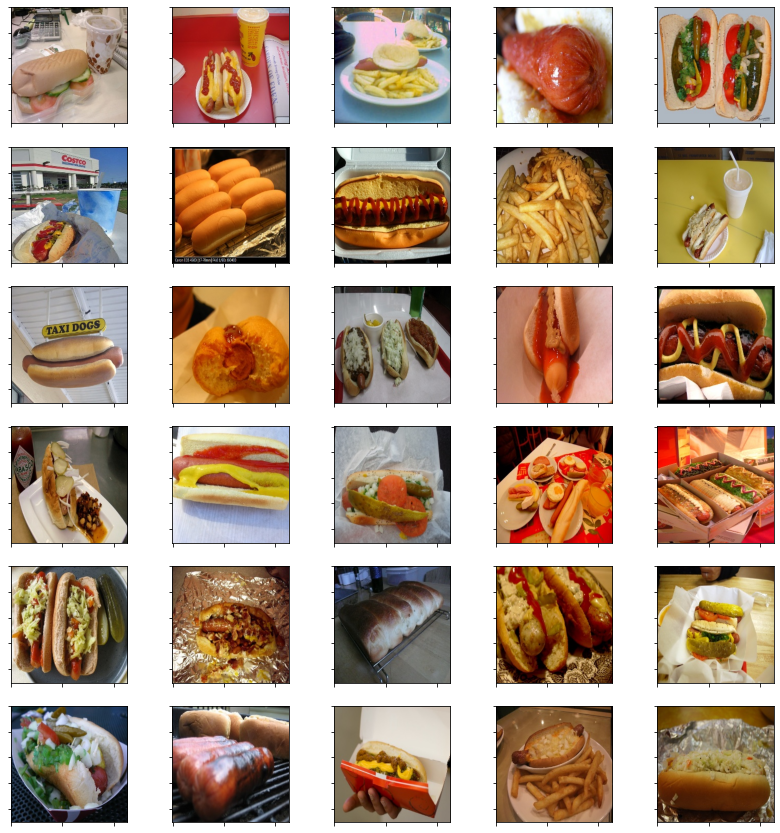

In [40]:
plt.subplots(6,5,figsize=(14,15))
for i in range(6):
    for j in range(5):
        ind = i*5+j
        img = np.float32(X_test[wrongs10[ind]])
        img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
        plt.subplot(6,5,i*5+j+1)
        ax = plt.gca()
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        plt.imshow(img)
plt.show()

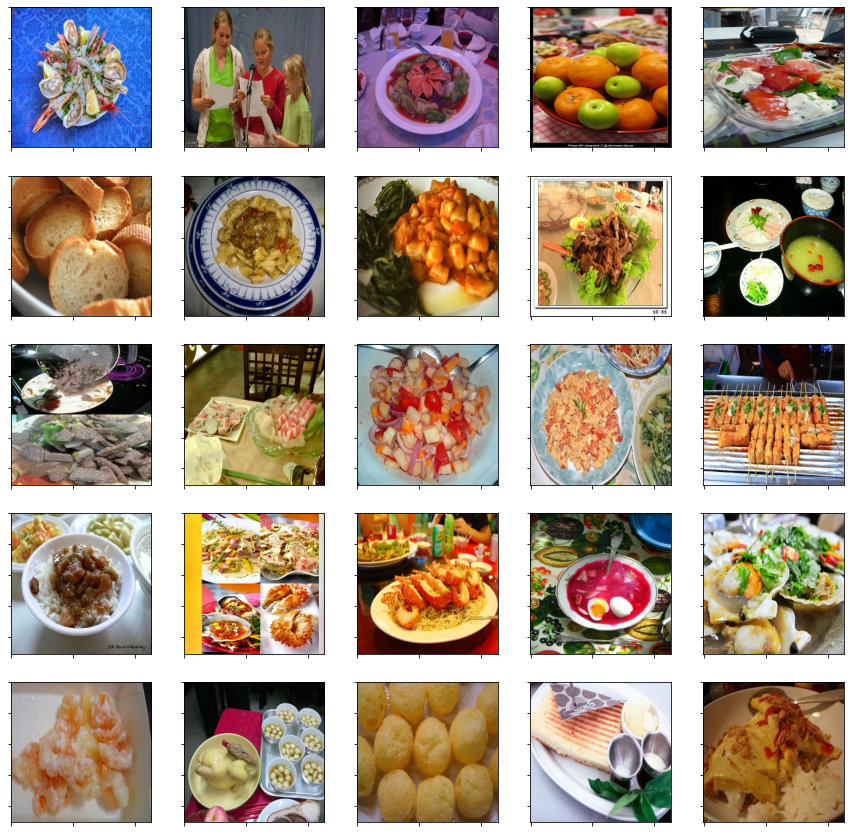

In [ ]:
plt.subplots(5,5,figsize=(15,15))
for i in range(5):
    for j in range(5):
        ind = i*5+j
        img = np.float32(X_test[wrongs01[ind]])
        img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
        plt.subplot(5,5,i*5+j+1)
        ax = plt.gca()
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        plt.imshow(img)
plt.show()

In [20]:
def url_to_image(url):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    # return the image
    return image

INFO:tensorflow:Restoring parameters from ./model.ckpt
Model Restored


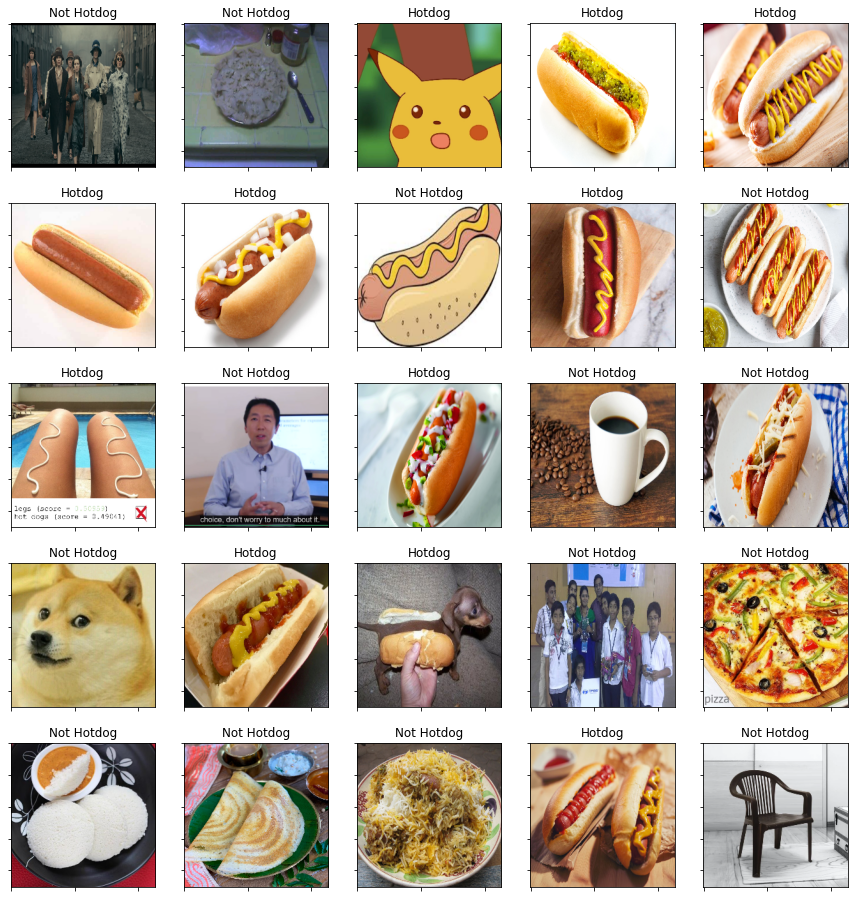

In [39]:
saver = tf.train.Saver()
plt.subplots(5,5,figsize=(15,16))
c = 1
with tf.Session() as sess:
    saver.restore(sess, "./model.ckpt")
    print("Model Restored")
    # url = ""
    # img = cv2.imread("./test/4.jpg") 
    # img = url_to_image(url)
    for fil in os.listdir("./test"):
        img = cv2.imread("./test/"+fil)   
        rimg = cv2.resize(img, (227,227))
        rimgd = rimg.reshape((1,227,227,3))
        rimgd = rimgd/255
        rimg = cv2.cvtColor(rimg, cv2.COLOR_BGR2RGB)
        plt.subplot(5,5,c); c+=1
        ax = plt.gca()
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        plt.imshow(rimg)
        preds = sess.run(y_pred,feed_dict={X:rimgd, hold_prob1:1.0,hold_prob2:1.0})
        title = "Hotdog" if ((preds[0] > 0.6)) else "Not Hotdog"
        plt.title(title)
plt.show()